In [98]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [99]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            577 non-null    object 
 1   Player          577 non-null    object 
 2   MatchId         577 non-null    object 
 3   Map             577 non-null    object 
 4   Category        577 non-null    object 
 5   Playlist        577 non-null    object 
 6   Input           577 non-null    object 
 7   Queue           577 non-null    object 
 8   Csr             577 non-null    int64  
 9   Mmr             1 non-null      float64
 10  Outcome         577 non-null    object 
 11  Accuracy        577 non-null    float64
 12  DamageDone      577 non-null    int64  
 13  DamageTaken     577 non-null    int64  
 14  ShotsFired      577 non-null    int64  
 15  ShotsLanded     577 non-null    int64  
 16  ShotsMissed     577 non-null    int64  
 17  KD              577 non-null    flo

In [100]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['Damage/Kill'] = df['DamageDone'] / df['Kills']
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['Shots/10Min'] = (df['ShotsFired'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
df['ExcessKD'] = df['KD'] - (df['ExpectedKills'] / df['ExpectedDeaths'])

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'Csr', 'ShotsFired', 
              'ShotsMissed', 'ShotsLanded', 'Betrayals', 'Suicides',
                'Perfects', 'Medals',
                'LengthSeconds'],axis=1)
dfR = df[df['Playlist'] == 'Ranked Arena']
dfRR = dfR[dfR['Date']> '2023-01-01']
dfRR = dfRR[dfRR['Outcome'] != 'Draw']
dfRR = dfRR[dfRR['Outcome'] != 'Left']
dfRR['Outcome'] = dfRR['Outcome'].map({'Win': 1, 'Loss': 0})
dfRR = dfRR.drop(['Date', 'Category', 'Playlist'], axis=1)
dfRR = dfRR.dropna()
dfRR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 140 to 576
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Map             364 non-null    object 
 1   Outcome         364 non-null    int64  
 2   Accuracy        364 non-null    float64
 3   DamageDone      364 non-null    int64  
 4   DamageTaken     364 non-null    int64  
 5   KD              364 non-null    float64
 6   KDA             364 non-null    float64
 7   Kills           364 non-null    int64  
 8   Deaths          364 non-null    int64  
 9   Assists         364 non-null    int64  
 10  ExpectedKills   364 non-null    float64
 11  ExpectedDeaths  364 non-null    float64
 12  Score           364 non-null    int64  
 13  LengthMinutes   364 non-null    float64
 14  DamageRatio     364 non-null    float64
 15  Damage/Kill     364 non-null    float64
 16  Kills/10Min     364 non-null    float64
 17  Deaths/10Min    364 non-null    f

In [101]:
def cnt(df, col):
    count = df[col].count()
    return count
def sm(df, col):
    sum = df[col].sum()
    return sum
def avg(df, col, val=None):
    avg = round(sm(df, col) / cnt(df, col),val)
    return avg


In [102]:
corr_mtrx = dfRR.corr().abs()
print(corr_mtrx['Outcome'].sort_values(ascending=False))

Outcome           1.000000
Deaths/10Min      0.457617
DmgT/10Min        0.367172
Deaths            0.332029
KD                0.319268
ExcessDeaths      0.282060
DamageRatio       0.259156
KDA               0.257147
DamageTaken       0.247650
ExcessKD          0.219759
ExpectedDeaths    0.216244
Assists/10Min     0.200656
Damage/Kill       0.149544
LengthMinutes     0.137678
DamageDone        0.115190
Kills/10Min       0.089460
Accuracy          0.079723
Assists           0.054126
Kills             0.051619
ExcessKills       0.050830
ExpectedKills     0.029178
Score             0.020177
Dmg/10Min         0.012843
Shots/10Min       0.001538
Name: Outcome, dtype: float64


In [103]:
# dfRR.hist(bins=15, figsize=(16, 12))
# plt.tight_layout()
# plt.show()

In [104]:
dfRR.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Outcome,364.0,0.530220,0.499773,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,364.0,52.089011,5.225734,36.800000,48.775000,52.350000,54.890000,80.560000
DamageDone,364.0,5115.706044,1819.703057,667.000000,3807.500000,4765.500000,6353.250000,12673.000000
DamageTaken,364.0,4417.379121,1544.249617,875.000000,3388.000000,4161.500000,5338.000000,9962.000000
KD,364.0,1.247225,0.675154,0.310000,0.860000,1.130000,1.430000,6.000000
KDA,364.0,4.366236,5.590584,-9.660000,0.660000,4.000000,7.660000,31.000000
Kills,364.0,14.458791,6.465501,1.000000,10.000000,14.000000,18.000000,40.000000
Deaths,364.0,12.824176,5.114326,1.000000,9.000000,12.000000,16.000000,30.000000
Assists,364.0,8.200549,4.103469,1.000000,6.000000,8.000000,10.000000,27.000000
ExpectedKills,364.0,14.255495,4.403617,3.000000,11.000000,13.000000,17.000000,28.000000


In [105]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [106]:
# Define features (X) and target variable (y)
X = dfRR.drop('Outcome', axis=1) 
X = round(X,20)
y = dfRR['Outcome'] 

print(f'X Shape: {X.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (364, 24)
Y Shape: (364,)


In [107]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=2)
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')

X Train Shape: (291, 24)
X Test Shape: (73, 24)


In [108]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['KD', 'KDA', 'Kills', 'Deaths', 'Assists', 'DamageDone', 'DamageTaken', 'DamageRatio', 
                                   'Damage/Kill', 'Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min', 'DmgT/10Min',
                                   'ExcessKills', 'ExcessDeaths', 'ExcessKD', 'ExpectedKills', 'ExpectedDeaths', 'Score', 'Shots/10Min']),
        ('cat', OneHotEncoder(), ['Map'])
    ])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

In [109]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MSE_Histmean = mean_squared_error(y_test,np.full(y_test.shape,np.mean(y_train)))

def ResultsOut(model):
  y_pred = model.predict(X_test_preprocessed)
  # Calculate regression metrics
  acc = model.score(X_test_preprocessed, y_test)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)
  oosr2 = 1-mean_squared_error(y_test,y_pred)/MSE_Histmean
  # Print the metrics with newline characters
  print("Acc: {:.3f}".format(acc))
  print("MAE: {:.2f}".format(mae))
  print("MSE: {:.2f}".format(mse))
  print("RMSE: {:.2f}".format(rmse))
  print("R^2 Score: {:.2f}".format(r2))
  print("OOS R^2 Score: {:.2f}".format(oosr2))
  return ''

def paramResults(mod):
    results_df = pd.DataFrame({'param': mod.cv_results_["params"], 'Accuracy': mod.cv_results_["mean_test_score"]})

    # Splitting the 'param' column into separate columns
    params_df = pd.DataFrame(results_df['param'].to_list())
    params_df.columns = [f"{col}_param" for col in params_df.columns]

    # Concatenating the new columns with the 'Accuracy' column
    results_df = pd.concat([params_df, results_df['Accuracy']], axis=1)

    # Displaying the updated DataFrame
    print(results_df)
    return ''

def featImport(mod):
    feat_importances = pd.DataFrame(mod.best_estimator_.feature_importances_[:20], index=X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    feat_importances.plot(kind='bar', figsize=(8,6))
    plt.show()

## Logistic Regression

In [110]:
# Unregularized Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(penalty=None)
logreg.fit(X_train_preprocessed, y_train)

print(f'Unregularized Logistic Regression Accuracy: {logreg.score(X_test_preprocessed, y_test)}')
print(ResultsOut(logreg))

Unregularized Logistic Regression Accuracy: 0.8356164383561644
Acc: 0.836
MAE: 0.16
MSE: 0.16
RMSE: 0.41
R^2 Score: 0.34
OOS R^2 Score: 0.34



## Ridge

In [111]:
# Ridge
# Need to find best params for param grid

C_grid = [10**-3,10**-2,10**-1,10**0,10**1,10**2]

param_grid={'C':C_grid}
ridge_cv = GridSearchCV(LogisticRegression(penalty='l2',solver='saga'),
                                          param_grid=param_grid,cv=5)
ridge_cv.fit(X_train_preprocessed,y_train)

print(ridge_cv.best_estimator_)
print(f'Ridge Accuracy: {ridge_cv.score(X_test_preprocessed, y_test)}')
ridge_cv.cv_results_
paramResults(ridge_cv)

LogisticRegression(C=1, solver='saga')
Ridge Accuracy: 0.821917808219178
   C_param  Accuracy
0    0.001  0.653068
1    0.010  0.694331
2    0.100  0.752659
3    1.000  0.787142
4   10.000  0.787025
5  100.000  0.787025


''

In [112]:
ResultsOut(ridge_cv)

Acc: 0.822
MAE: 0.18
MSE: 0.18
RMSE: 0.42
R^2 Score: 0.28
OOS R^2 Score: 0.28


''

## Lasso

In [113]:
# Lasso

param_grid={'C':C_grid}
lasso_cv = GridSearchCV(LogisticRegression(penalty='l1',solver='saga'),
                                          param_grid=param_grid,cv=5)
lasso_cv.fit(X_train_preprocessed,y_train)

print(lasso_cv.best_estimator_)
print(f'Lasso Accuracy: {lasso_cv.score(X_test_preprocessed, y_test)}')
lasso_cv.cv_results_
paramResults(lasso_cv)


LogisticRegression(C=1, penalty='l1', solver='saga')
Lasso Accuracy: 0.8356164383561644
   C_param  Accuracy
0    0.001  0.515430
1    0.010  0.529223
2    0.100  0.701052
3    1.000  0.787084
4   10.000  0.783577
5  100.000  0.787025


''

In [114]:
ResultsOut(lasso_cv)

Acc: 0.836
MAE: 0.16
MSE: 0.16
RMSE: 0.41
R^2 Score: 0.34
OOS R^2 Score: 0.34


''

## ElasticNet

In [115]:
# ElasticNet

param_grid2={'C':C_grid,'l1_ratio':[.25, .5, .75]}

elastic_cv = GridSearchCV(LogisticRegression(penalty='elasticnet',solver='saga'),
                                            param_grid=param_grid2,cv=5)
elastic_cv.fit(X_train_preprocessed,y_train)

print(elastic_cv.best_estimator_)
print(f'ElasticNet Accuracy: {elastic_cv.score(X_test_preprocessed, y_test)}')
elastic_cv.cv_results_
paramResults(elastic_cv)

LogisticRegression(C=1, l1_ratio=0.5, penalty='elasticnet', solver='saga')
ElasticNet Accuracy: 0.8082191780821918
    C_param  l1_ratio_param  Accuracy
0     0.001            0.25  0.519053
1     0.001            0.50  0.515430
2     0.001            0.75  0.515430
3     0.010            0.25  0.680538
4     0.010            0.50  0.529223
5     0.010            0.75  0.529223
6     0.100            0.25  0.728521
7     0.100            0.50  0.718293
8     0.100            0.75  0.690707
9     1.000            0.25  0.783694
10    1.000            0.50  0.790532
11    1.000            0.75  0.790532
12   10.000            0.25  0.783577
13   10.000            0.50  0.783577
14   10.000            0.75  0.783577
15  100.000            0.25  0.787025
16  100.000            0.50  0.790473
17  100.000            0.75  0.787025


''

In [116]:
ResultsOut(elastic_cv)

Acc: 0.808
MAE: 0.19
MSE: 0.19
RMSE: 0.44
R^2 Score: 0.23
OOS R^2 Score: 0.23


''

## K-Nearest Neighbours

In [117]:
# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

k_values = list(range(1,50,3))
param_grid = {'n_neighbors': k_values}

knn_cv = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,n_jobs=-1)
knn_cv.fit(X_train_preprocessed,y_train)

print(knn_cv.best_estimator_)
print(f'K-Nearest Neighbors Accuracy: {knn_cv.score(X_test_preprocessed, y_test)}')
knn_cv.cv_results_
paramResults(knn_cv)

KNeighborsClassifier(n_neighbors=40)
K-Nearest Neighbors Accuracy: 0.7123287671232876
    n_neighbors_param  Accuracy
0                   1  0.666569
1                   4  0.663296
2                   7  0.642665
3                  10  0.663238
4                  13  0.666628
5                  16  0.690649
6                  19  0.704442
7                  22  0.676856
8                  25  0.680479
9                  28  0.677089
10                 31  0.697662
11                 34  0.687376
12                 37  0.704442
13                 40  0.708007
14                 43  0.697487
15                 46  0.690649
16                 49  0.697545


''

In [118]:
ResultsOut(knn_cv)

Acc: 0.712
MAE: 0.29
MSE: 0.29
RMSE: 0.54
R^2 Score: -0.16
OOS R^2 Score: -0.16


''

## Random Forest

In [119]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {'n_estimators': [100,300,500],'max_depth': [10, 15, 20]}
rf_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=69,max_features='sqrt'),
                                                     cv=5, param_grid=param_grid_rf,n_jobs=-1)
rf_cv.fit(X_train_preprocessed, y_train)

print(rf_cv.best_estimator_)
print(f'Random Forest Accuracy: {rf_cv.score(X_test_preprocessed, y_test)}')
rf_cv.cv_results_
paramResults(rf_cv)

RandomForestClassifier(max_depth=20, n_estimators=300, random_state=69)
Random Forest Accuracy: 0.7671232876712328
   max_depth_param  n_estimators_param  Accuracy
0               10                 100  0.728638
1               10                 300  0.725307
2               10                 500  0.725365
3               15                 100  0.711514
4               15                 300  0.725307
5               15                 500  0.725307
6               20                 100  0.708065
7               20                 300  0.728755
8               20                 500  0.725307


''

In [120]:
ResultsOut(rf_cv)

Acc: 0.767
MAE: 0.23
MSE: 0.23
RMSE: 0.48
R^2 Score: 0.06
OOS R^2 Score: 0.06


''

<AxesSubplot: >

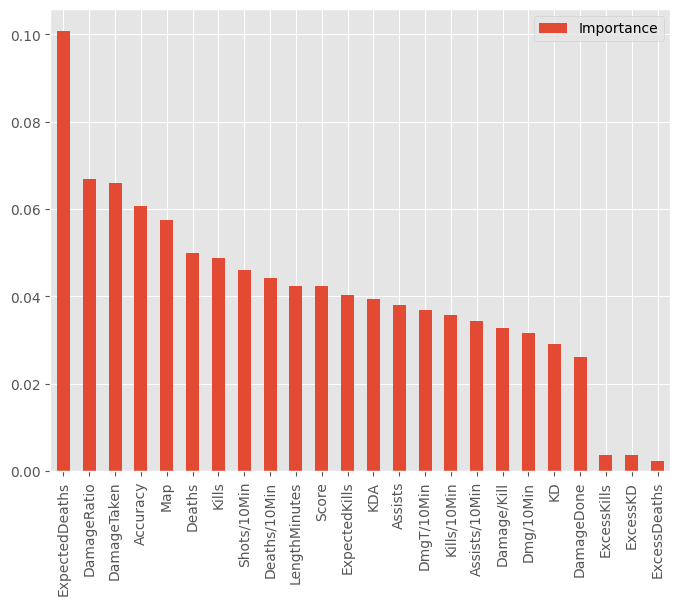

In [121]:
feat_importances = pd.DataFrame(rf_cv.best_estimator_.feature_importances_[:24], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Gradient Boosted Trees

In [122]:
# Gradient Boosted Trees
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbrt = {'n_estimators': [100,300,500],'learning_rate': [0.01,0.1],'max_depth': [2,4,6], 'subsample': [0.5,1]}
GBRT = GridSearchCV(estimator=GradientBoostingClassifier(random_state=69),
                    cv=5, param_grid=param_grid_gbrt,n_jobs=-1)
GBRT.fit(X_train_preprocessed, y_train)

print(GBRT.best_estimator_)
print(f'Gradient Boosed Trees Accuracy: {GBRT.score(X_test_preprocessed, y_test)}')
GBRT.cv_results_
paramResults(GBRT)

GradientBoostingClassifier(max_depth=4, n_estimators=300, random_state=69,
                           subsample=1)
Gradient Boosed Trees Accuracy: 0.7123287671232876
    learning_rate_param  max_depth_param  n_estimators_param  subsample_param  \
0                  0.01                2                 100              0.5   
1                  0.01                2                 100              1.0   
2                  0.01                2                 300              0.5   
3                  0.01                2                 300              1.0   
4                  0.01                2                 500              0.5   
5                  0.01                2                 500              1.0   
6                  0.01                4                 100              0.5   
7                  0.01                4                 100              1.0   
8                  0.01                4                 300              0.5   
9                  0.01 

''

In [123]:
ResultsOut(GBRT)

Acc: 0.712
MAE: 0.29
MSE: 0.29
RMSE: 0.54
R^2 Score: -0.16
OOS R^2 Score: -0.16


''

<AxesSubplot: >

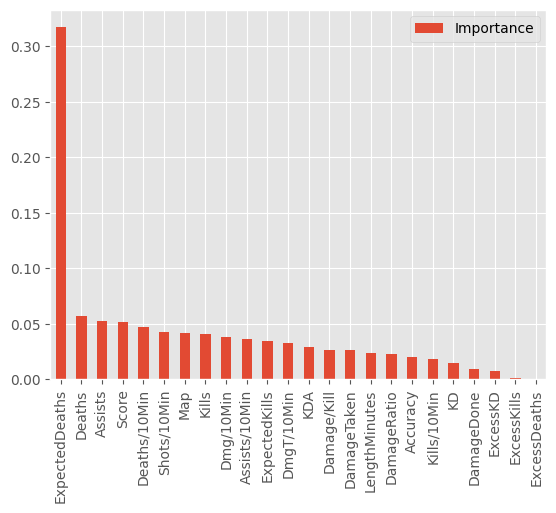

In [124]:
feat_importances = pd.DataFrame(GBRT.best_estimator_.feature_importances_[:24], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

## XGBoost

In [125]:
from xgboost import XGBClassifier

param_grid_xgb = {'n_estimators': [400,450,475,500],'learning_rate': [0.001,0.01,0.1,0.25],'max_depth': [1,2,3,4,5]}
XGB = GridSearchCV(estimator=XGBClassifier(random_state=69), cv=5, param_grid=param_grid_xgb,n_jobs=-1)
XGB.fit(X_train_preprocessed, y_train)

print(XGB.best_estimator_)
print(f'XGBoost Accuracy: {XGB.score(X_test_preprocessed, y_test)}')
paramResults(XGB)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=69, ...)
XGBoost Accuracy: 0.7397260273972602
    learning_rate_param  max_depth_param  n_estimators_param  Accuracy
0                 0.001                1                 400  0.694155
1                 0.001                1                 450  0.694155
2   

''

In [126]:
ResultsOut(XGB)

Acc: 0.740
MAE: 0.26
MSE: 0.26
RMSE: 0.51
R^2 Score: -0.05
OOS R^2 Score: -0.05


''

<AxesSubplot: >

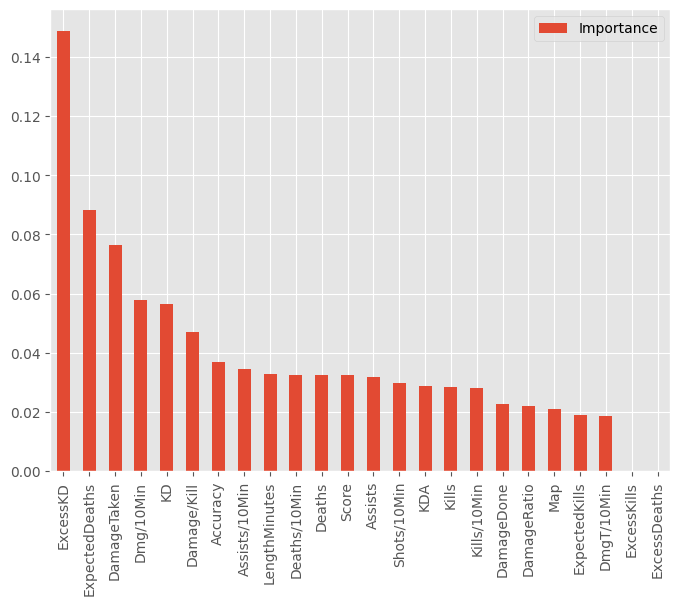

In [127]:
feat_importances = pd.DataFrame(XGB.best_estimator_.feature_importances_[:24], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

Runtime: 25.49s


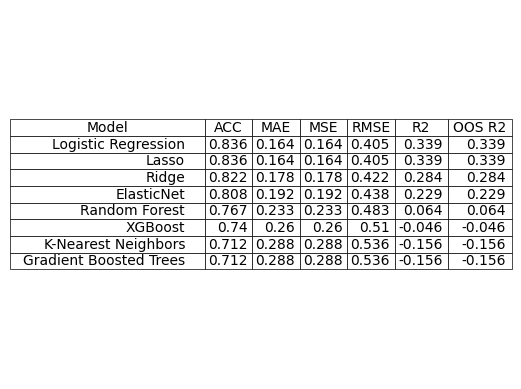

In [128]:
modelss = [logreg,ridge_cv,lasso_cv,elastic_cv,knn_cv,rf_cv,GBRT,XGB]
model_namess = ['Logistic Regression', 'Ridge', 'Lasso', 'ElasticNet',
              'K-Nearest Neighbors', 'Random Forest', 'Gradient Boosted Trees', 'XGBoost']
def saveResults(models, model_names):
    # Initialize an empty dataframe to store the metrics
    metrics_df = pd.DataFrame(columns=['Model', 'ACC' ,'MAE', 'MSE', 'RMSE', 'R2', 'OOS R2'])
    
    # Loop through each model and calculate the metrics
    for i, model in enumerate(models):
        # Generate predictions on the test set
        y_pred = model.predict(X_test_preprocessed)
        
        # Calculate regression metrics
        acc = round(model.score(X_test_preprocessed, y_test),3)
        mae = round(mean_absolute_error(y_test, y_pred),3)
        mse = round(mean_squared_error(y_test, y_pred),3)
        rmse = round(mean_squared_error(y_test, y_pred, squared=False),3)
        r2 = round(r2_score(y_test, y_pred),3)
        oosr2 = round(1-mean_squared_error(y_test,y_pred)/MSE_Histmean,3)
        
        # Add metrics to the dataframe
        metrics_df.loc[i] = [model_names[i],acc, mae, mse, rmse, r2, oosr2]
    
    metrics_df = metrics_df.sort_values('ACC', ascending=False).reset_index(drop=True)

    fig, ax = plt.subplots()
    table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                     cellLoc='right', loc='center')
    table.auto_set_font_size(True)
    table.auto_set_column_width(col=list(range(len(metrics_df.columns))))
    ax.axis('off')
    plt.savefig('ModelResults1219.png', dpi=300, bbox_inches='tight')
    
    return metrics_df

saveResults(modelss,model_namess)
print(f'Runtime: {round(time.perf_counter() - start,2)}s')